In [19]:
import numpy as np
import random
import matplotlib.pyplot as plt

### Configuration des données et calculs géographiques

In [20]:

cities = [
    ("Tanger", 35.7595, -5.8339),
    ("Tétouan", 35.5785, -5.3684),
    ("Fès", 34.0331, -5.0003),
    ("Rabat", 34.0209, -6.8417),
    ("Casablanca", 33.5731, -7.5898),
    ("Marrakech", 31.6295, -7.9811),
    ("Agadir", 30.4278, -9.5981),
    ("Oujda", 34.6833, -1.9167),
    ("Meknès", 33.8935, -5.5473),
    ("Laâyoune", 27.1536, -13.2033)
]

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def compute_distance_matrix(cities):
    n = len(cities)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dist_matrix[i][j] = haversine_distance(
                    cities[i][1], cities[i][2],
                    cities[j][1], cities[j][2]
                )
    return dist_matrix

def get_city_coordinates_3d(cities):
    return np.array([[lon * 100, lat * 100, 0] for (_, lat, lon) in cities])

## Implémentation de l'algorithme MCEO

### Initialisation et échantillonnage

In [21]:
def initialize(n_cities, n_averages):
    averages, sigmas = [], []
    for _ in range(n_averages):
        prob_matrix = np.ones((n_cities, n_cities)) / (n_cities - 1)
        np.fill_diagonal(prob_matrix, 0)
        averages.append(prob_matrix)
        sigmas.append(0.5 * (1.0 / n_averages))  # Reduced initial sigma
    return averages, sigmas

def sample_tour(prob_matrix):
    n_cities = prob_matrix.shape[0]
    tour, visited = [], set()
    current = random.randint(0, n_cities - 1)
    tour.append(current)
    visited.add(current)

    while len(tour) < n_cities:
        probs = prob_matrix[current].copy()
        for v in visited:
            probs[v] = 0
        if probs.sum() == 0:
            next_city = random.choice([c for c in range(n_cities) if c not in visited])
        else:
            probs /= probs.sum()
            next_city = np.random.choice(range(n_cities), p=probs)
        tour.append(next_city)
        visited.add(next_city)
        current = next_city

    return tour

In [22]:
def calculate_distance(tour, distance_matrix):
    return sum(distance_matrix[tour[i], tour[(i + 1) % len(tour)]] for i in range(len(tour)))
def update_prob_matrix(tours, n_cities):
    prob_matrix = np.zeros((n_cities, n_cities))
    for tour in tours:
        for i in range(len(tour)):
            u, v = tour[i], tour[(i + 1) % len(tour)]
            prob_matrix[u, v] += 1
            prob_matrix[v, u] += 1
    row_sums = prob_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    prob_matrix /= row_sums
    np.fill_diagonal(prob_matrix, 0)
    return prob_matrix

### Fonction d'optimisation principale

In [23]:
def optimize_mceo(distance_matrix, n_averages=5, n_search_agents=20, max_iter=100, alpha=0.2, srf_range=(0.9, 1.1)):
    n_cities = distance_matrix.shape[0]
    srf_min, srf_max = srf_range
    averages, sigmas = initialize(n_cities, n_averages)
    best_tour, best_distance = None, float('inf')
    last_printed_dist = float('inf')
    last_printed_global = float('inf')
    
    history = {'iteration': [], 'current_best': [], 'global_best': []}

    for iteration in range(max_iter):
        all_tours, all_distances = [], []

        for i, (avg, sigma) in enumerate(zip(averages, sigmas)):
            for _ in range(n_search_agents):
                perturbed = avg + 0.3 * np.random.normal(0, sigma, size=avg.shape)
                perturbed = np.maximum(perturbed, 0)
                np.fill_diagonal(perturbed, 0)
                row_sums = np.sum(perturbed, axis=1, keepdims=True)
                row_sums[row_sums == 0] = 1
                perturbed /= row_sums

                tour = sample_tour(perturbed)
                dist = calculate_distance(tour, distance_matrix)
                all_tours.append((i, tour, dist))
                all_distances.append(dist)

        sorted_indices = np.argsort(all_distances)
        sorted_tours = [all_tours[i] for i in sorted_indices]
        current_best_dist = all_distances[sorted_indices[0]]

        history['iteration'].append(iteration+1)
        history['current_best'].append(current_best_dist)
        
        improved = False
        if current_best_dist < best_distance:
            best_distance = current_best_dist
            best_tour = sorted_tours[0][1]
            improved = True
        
        history['global_best'].append(best_distance)

        print_iteration = False
        current_diff = abs(current_best_dist - last_printed_dist)
        global_diff = abs(best_distance - last_printed_global)
        
        if iteration == 0 or iteration == max_iter - 1:
            print_iteration = True
        elif improved and global_diff > 0.1:
            print_iteration = True
        elif iteration % 10 == 0 and current_diff > 0.5:
            print_iteration = True

        if print_iteration:
            print(f"Iteration {iteration + 1:3d}: Current = {current_best_dist:7.2f} km | Global = {best_distance:7.2f} km {'*' if improved else ''}")
            last_printed_dist = current_best_dist
            last_printed_global = best_distance

        n_keep = int(n_averages * (1 - alpha))
        top_performers = sorted_tours[:n_keep * n_search_agents]
        avg_groups = {}
        for avg_idx, tour, dist in top_performers:
            if avg_idx not in avg_groups or dist < avg_groups[avg_idx][1]:
                avg_groups[avg_idx] = (tour, dist)

        new_averages = [update_prob_matrix([tour], n_cities) for tour, _ in avg_groups.values()]
        for _ in range(n_averages - len(new_averages)):
            prob_matrix = np.ones((n_cities, n_cities)) / (n_cities - 1)
            np.fill_diagonal(prob_matrix, 0)
            new_averages.append(prob_matrix)

        srf_values = np.linspace(srf_min, srf_max, n_averages)
        new_sigmas = []
        for i in range(n_averages):
            rank_factor = (i + 1) / n_averages
            sigma = 0.3 * (rank_factor ** 2) * (1.0 / n_cities)
            sigma *= srf_values[i]
            new_sigmas.append(sigma)

        averages, sigmas = new_averages, new_sigmas

        if iteration > 20 and np.std(all_distances[:n_averages * n_search_agents]) < 0.1:
            print(f"\nConvergence atteinte à l'itération {iteration + 1}")
            break

    return best_tour, best_distance, history


## Visualisation des résultats

### Graphique de convergence

In [24]:
def plot_convergence(history):
    plt.figure(figsize=(12, 6))
    # plt.plot(history['iteration'], history['current_best'], 'b-', alpha=0.3, label='Meilleur courant')
    plt.plot(history['iteration'], history['global_best'], 'r-', linewidth=2, label='Meilleur global')
    plt.xlabel('Itération')
    plt.ylabel('Distance (km)')
    plt.title('Convergence de l\'algorithme MCEO')
    plt.legend()
    plt.grid(True)
    plt.show()

### Représentation des tours

In [25]:
def plot_tours(coords, best_tour, city_names):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].set_title("Connexions complètes entre villes")
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            axes[0].plot([coords[i][0], coords[j][0]], [coords[i][1], coords[j][1]], color='lightgray', linewidth=0.3)
    axes[0].scatter(coords[:, 0], coords[:, 1], color='blue', s=80)
    for idx, (x, y, _) in enumerate(coords):
        axes[0].text(x + 15, y + 15, city_names[idx], fontsize=9, ha='center')

    axes[1].set_title(f"Meilleur tour trouvé ({len(best_tour)} villes)")
    tour_coords = coords[np.append(best_tour, best_tour[0])]
    axes[1].plot(tour_coords[:, 0], tour_coords[:, 1], 'o-', color='green', 
                linewidth=2, markersize=8, markerfacecolor='yellow')
    for idx in best_tour:
        x, y, _ = coords[idx]
        axes[1].text(x + 15, y + 15, city_names[idx], fontsize=9, ha='center')

    plt.tight_layout()
    plt.show()

## Exécution et analyse

Démarrage de l'optimisation...
Iteration   1: Current = 3444.77 km | Global = 3444.77 km *
Iteration   2: Current = 3382.05 km | Global = 3382.05 km *
Iteration   3: Current = 3226.50 km | Global = 3226.50 km *
Iteration   5: Current = 3137.00 km | Global = 3137.00 km *
Iteration  20: Current = 3129.12 km | Global = 3129.12 km *
Iteration  24: Current = 3097.22 km | Global = 3097.22 km *
Iteration  34: Current = 3068.47 km | Global = 3068.47 km *
Iteration  35: Current = 3037.88 km | Global = 3037.88 km *
Iteration  41: Current = 3017.13 km | Global = 3017.13 km *
Iteration  56: Current = 3014.38 km | Global = 3014.38 km *
Iteration  59: Current = 2996.92 km | Global = 2996.92 km *
Iteration  63: Current = 2963.04 km | Global = 2963.04 km *
Iteration 100: Current = 2963.04 km | Global = 2963.04 km 

Résultats finaux
Meilleur chemin trouvé :
1. Tétouan
2. Tanger
3. Rabat
4. Casablanca
5. Laâyoune
6. Agadir
7. Marrakech
8. Meknès
9. Fès
10. Oujda
Distance totale : 2963.04 km


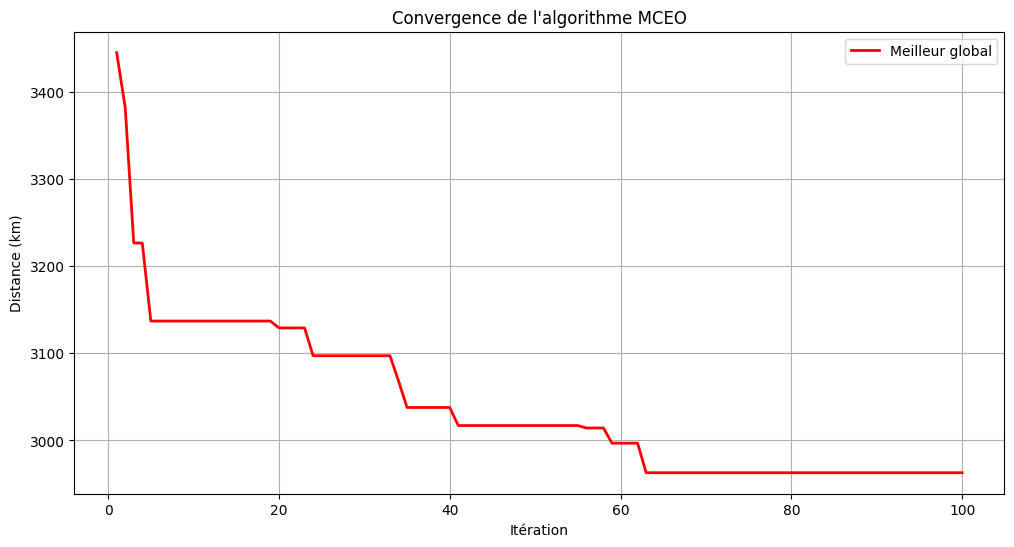

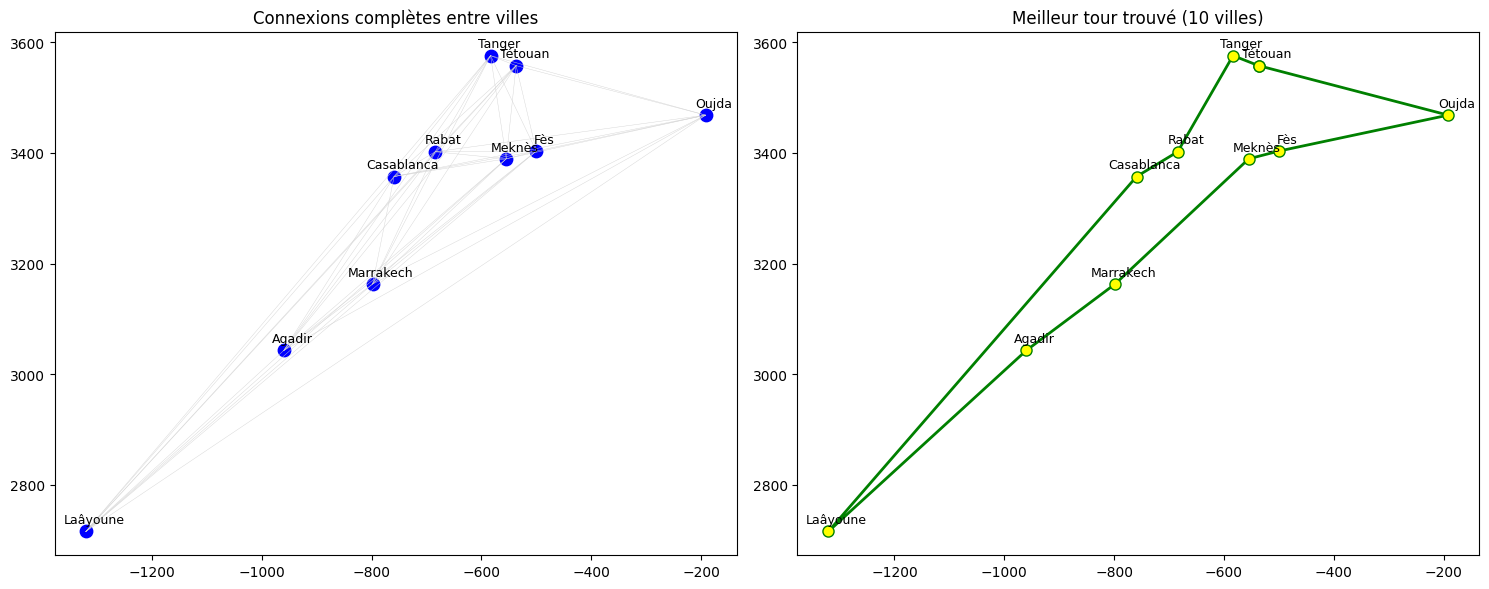

In [26]:
if __name__ == "__main__":
    np.random.seed(42)
    random.seed(42)
    
    distance_matrix = compute_distance_matrix(cities)
    coords = get_city_coordinates_3d(cities)
    city_names = [name for name, _, _ in cities]

    print("Démarrage de l'optimisation...")
    best_tour, best_distance, history = optimize_mceo(
        distance_matrix, 
        n_averages=7,       
        n_search_agents=25,  
        max_iter=100,
        alpha=0.15        
    )

    print("\nRésultats finaux")
    print("Meilleur chemin trouvé :")
    for i, city_idx in enumerate(best_tour):
        print(f"{i+1}. {city_names[city_idx]}")
    print(f"Distance totale : {best_distance:.2f} km")

    plot_convergence(history)
    plot_tours(coords, best_tour, city_names)